In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Extract Data từ file XML - Chuẩn bị dữ liệu cho Yolov8 - Chuẩn bị dữ liệu cho CRNN

In [7]:

def extract_data_from_xml(root_dir):
    """
    Trích xuất dữ liệu từ file words.xml trong bộ IC03

    Hàm này dùng để trích các thông tin từ file .xml bao gồm:
    image paths, image sizes, image labels và bboxes

    Parameters:
        root_dir (str): Đường dẫn đến thư mục root của dataset

    Returns:
        tuple: Chứa 4 lists lần lượt là: image paths, image sizes, image labels, và bboxes.
    """

    # Tạo path đến file words.xml
    xml_path = os.path.join(root_dir, 'words.xml')
    # Parse file xml
    tree = ET.parse(xml_path)
    # Đọc thẻ root của file
    root = tree.getroot()

    # Khai báo các list rỗng để lưu dữ liệu
    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    # Duyệt qua từng thẻ ảnh <image>
    for img in root:
        # Khai báo các list rỗng chứa bboxes và labels của ảnh đang xét
        bbs_of_img = []
        labels_of_img = []

        # Duyệt qua từng thẻ boundingbox
        for bbs in img.findall('taggedRectangles'):
            for bb in bbs:
                # Bỏ qua trường hợp label không phải kí tự alphabet hoặc number
                if not bb[0].text.isalnum():
                    continue

                # Bỏ qua trường hợp label là chữ 'é' hoặc ñ'
                if 'é' in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
                    continue

                # Đưa thông tin tọa độ bbox vào list bbs_of_img
                # Format bbox: (xmin, ymin, bbox_width, bbox_height)
                bbs_of_img.append(
                    [
                        float(bb.attrib['x']),
                        float(bb.attrib['y']),
                        float(bb.attrib['width']),
                        float(bb.attrib['height'])
                    ]
                )
                # Đưa label vào list labels_of_img (đã chuyển chữ viết thường)
                labels_of_img.append(bb[0].text.lower())

        # Đưa thông tin path ảnh đang xét vào list img_paths
        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        # Đưa thông tin độ phân giải ảnh vào list img_sizes
        img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
        # Đưa list bbox vào list bboxes
        bboxes.append(bbs_of_img)
        # Đưa list labels vào list img_labels
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes


def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu cho Text Recognition.

    Hàm sẽ tạo một thư mục save_dir, lưu các ảnh cắt từ tọa độ bbox.
    Label sẽ được lưu riêng vào file labels.txt.

    Parameters:
        img_paths (list): Danh sách các path ảnh.
        img_labels (list): Danh sách chứa danh sách labels của các ảnh.
        bboxes (list): Danh sách chứa danh sách bounding box của các ảnh.
        save_dir (str): Đường dẫn đến thư mục chứa dữ liệu.
    """
    # Tạo tự động thư mục chứa dữ liệu
    os.makedirs(save_dir, exist_ok=True)

    # Khai báo biến đếm và danh sách rỗng chứa labels
    count = 0
    labels = []

    # Duyệt qua từng cặp (đường dẫn ảnh, list label, list bbox)
    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        # Đọc ảnh
        img = Image.open(img_path)

        # Duyệt qua từng cặp label và bbox
        for label, bb in zip(img_label, bbs):
            # Cắt ảnh theo bbox
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Bỏ qua trường hợp 90% nội dung ảnh cắt là màu trắng hoặc đen.
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            # Bỏ qua trường hợp ảnh cắt có width < 10 hoặc heigh < 10
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Bỏ qua trường hợp số kí tự của label < 3
            if len(label) < 3:
                continue

            # Tạo tên cho file ảnh đã cắt và lưu vào save_dir
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            # Đưa format label mới vào list labels
            # Format: img_path\tlabel
            label = new_img_path + '\t' + label

            labels.append(label)  # Append label to the list

            count += 1

    print(f"Created {count} images")

    # Đưa list labels vào file labels.txt
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f"{label}\n")


def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    """
    Thực hiện normalize bounding box

    Parameters:
        image_paths (list): Danh sách chứa các path ảnh.
        image_sizes (list): Danh sách chứa độ phân giải ảnh.
        bounding_boxes (list): Danh sách chứa danh sách bounding box.

    Returns:
        yolov8_data (list): Danh sách gồm (image_path, image_size, bboxes)
    """
    # Khai báo list rỗng để chứa kết quả
    yolov8_data = []

    # Duyệt qua từng bộ path, resolution và bboxes ảnh.
    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        # Khai báo list rỗng để chứa label (format mới)
        yolov8_labels = []

        # Duyệt qua từng bbox
        for bbox in bboxes:
            x, y, w, h = bbox

            # Thực hiện normalize bbox
            # Format bbox hiện tại: (x_min, y_min, width, height)
            # Format bbox của yolo: (x_center, y_center, width, height)
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Mã class, mặc định = 0 vì chỉ có 1 class 'text'
            class_id = 0

            # Đổi format label
            # Format: "class_id x_center y_center width height"
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data


def save_data(data, save_dir):
    """
    Xây dựng thư mục chứa dữ liệu theo format YOLO

    Parameters:
        data (list): Danh sách chứa thông tin label ảnh.
        src_img_dir (str): Path đến thư mục dữ liệu gốc.
        save_dir (str): Path đến thư mục dữ liệu mới.
    """
    # Tạo thư mục dữ liệu mới nếu chưa có
    os.makedirs(save_dir, exist_ok=True)

    # Tạo thư mục 'images' và 'labels'
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    # Duyệt qua từng bộ path, bbox, label ảnh
    for image_path, yolov8_labels in data:
        # Copy ảnh từ thư mục gốc sang thư mục 'images'
        shutil.copy(
            image_path,
            os.path.join(save_dir, 'images')
        )

        # Ghi nội dung label vào file image_name.txt ở thư mục 'labels'
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"), 'w') as f:
            for label in yolov8_labels:
                f.write(f"{label}\n")


dataset_dir = '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain'
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)

#Thực hiện tạo OCR_Dataset
save_dir = '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)


# Định nghĩa class
class_labels = ['text']

# Thực hiện lời gọi hàm
yolov8_data = convert_to_yolov8_format(
    img_paths,
    img_sizes,
    bboxes
)
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolov8_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)
print(train_data)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)
# Thực hiện lời gọi hàm cho 3 set train, val, test
save_yolo_data_dir = '/content/drive/MyDrive/AI/OCR/datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(
    save_yolo_data_dir,
    'train'
)
print(save_yolo_data_dir)
save_val_dir = os.path.join(
    save_yolo_data_dir,
    'val'
)
save_test_dir = os.path.join(
    save_yolo_data_dir,
    'test'
)

save_data(
    train_data,
    save_train_dir
)
save_data(
    test_data,
    save_val_dir
)
save_data(
    val_data,
    save_test_dir
)
data_yaml = {
    'path': '/content/drive/MyDrive/AI/OCR/datasets/yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)


Created 928 images
[('/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2506.JPG', ['0 0.46953125 0.521875 0.7921875 0.29791666666666666']), ('/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2627.JPG', ['0 0.35703125 0.4354166666666667 0.5046875 0.075', '0 0.24609375 0.5854166666666667 0.2578125 0.0875', '0 0.72265625 0.43020833333333336 0.1859375 0.07708333333333334']), ('/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2653.JPG', ['0 0.49296875 0.5260416666666666 0.7796875 0.21458333333333332']), ('/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2510.JPG', ['0 0.2234375 0.6354166666666666 0.24375 0.125', '0 0.55625 0.6291666666666667 0.3375 0.19583333333333333', '0 0.41484375 0.403125 0.5453125 0.16041666666666668']), ('/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2490.JPG', ['0 0.471875 0.4395833333333333 0.74375 0.38333333333333336']), ('/

In [12]:
print(img_paths)

['/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1269.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1281.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1282.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1283.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1284.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1285.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1286.JPG', '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1288.JPG', '/content/drive/MyDr

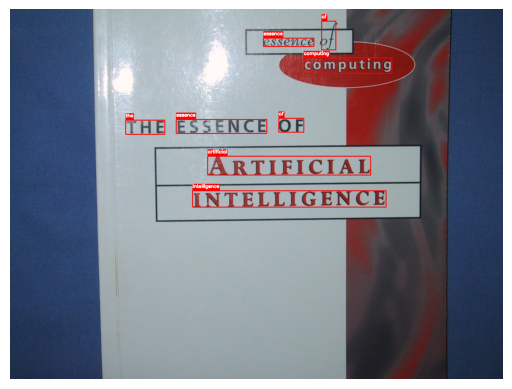

In [13]:
import random
def plot_image_with_bbs(img_path, bbs, labels):
    """
    Trực quan hóa bounding box với label lên ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        bbs (list): Danh sách các bounding box.
        labels (list): Danh sách các label.
    """
    # Đọc ảnh
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Duyệt qua từng bounding box
    for idx, bb in enumerate(bbs):
        # Vẽ bounding box lên ảnh
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        # Vẽ label lên cạnh bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        line_type = 2
        text_thickness = 2
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)


        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)


        cv2.putText(
            img,
            label,
            (int(bb[0]), int(bb[1] - 10)),
            font,
            font_scale,
            font_color,
            text_thickness,
            line_type
        )

    # Show ảnh
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Random chỉ mục của một ảnh bất kỳ để visualize
i = random.randint(0, len(img_paths))
plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])

# Sử dụng Yolov8 để phát hiện vùng văn bản

In [14]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.1/78.2 GB disk)


In [ ]:
from ultralytics import YOLO
#sss
# Load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')

# Train the model
epochs = 100
imgsz = 1024
yolo_yaml_path = '/content/drive/MyDrive/AI/OCR/datasets/yolo_data/data.yml'
results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    imgsz=imgsz,
    project='/content/drive/MyDrive/AI/OCR/models',
    name='yolov8/detect/train'
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 87.8MB/s]


Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/drive/MyDrive/AI/OCR/datasets/yolo_data/data.yml, epochs=100, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/AI/OCR/models, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

100%|██████████| 6.23M/6.23M [00:00<00:00, 70.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AI/OCR/datasets/yolo_data/train/labels.cache... 201 images, 82 backgrounds, 0 corrupt: 100%|██████████| 276/276 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/AI/OCR/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/AI/OCR/models/yolov8/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/AI/OCR/models/yolov8/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.56G       1.79      5.768      1.636         12       1024: 100%|██████████| 18/18 [00:24<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]

                   all         43        200       0.58      0.601      0.581      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.68G      1.087       2.11      1.179         13       1024: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200      0.344      0.695      0.327      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.87G       1.17      1.526      1.167         21       1024: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         43        200      0.377       0.24      0.204      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.87G      1.225      1.538      1.224         26       1024: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]

                   all         43        200      0.178       0.58      0.173     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.99G      1.256      1.668      1.279         10       1024: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         43        200       0.19      0.305      0.182     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       9.7G      1.263      1.512       1.25         26       1024: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         43        200      0.209      0.615      0.231     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100        10G      1.292      1.499      1.259         10       1024: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.322      0.465      0.322      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100        10G      1.199      1.359      1.193         22       1024: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         43        200      0.212      0.376      0.231      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.83G       1.18      1.358      1.221         25       1024: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200       0.74       0.67      0.711      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        10G      1.171      1.317      1.194         49       1024: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.669       0.58      0.621      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.98G      1.108      1.285      1.184         22       1024: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.558      0.595       0.62       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.96G      1.212      1.309       1.25         22       1024: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.673      0.665      0.668      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.63G      1.137      1.186      1.157         35       1024: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200      0.647      0.725      0.662      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.71G      1.127      1.216      1.185         34       1024: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200       0.72      0.696      0.761      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.89G      1.164      1.238      1.212         24       1024: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         43        200      0.714      0.765      0.738      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100        10G      1.135      1.189      1.203         31       1024: 100%|██████████| 18/18 [00:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         43        200      0.698      0.805      0.807      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       9.9G      1.064      1.159      1.125         22       1024: 100%|██████████| 18/18 [00:17<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         43        200      0.795      0.755       0.79      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.94G      1.084      1.155      1.139         31       1024: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         43        200      0.747      0.805       0.82      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100        10G      1.082      1.125      1.159         48       1024: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         43        200      0.834      0.776      0.844      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.95G       1.09       1.25      1.176         17       1024: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         43        200      0.727      0.775       0.78       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.72G      1.095      1.188      1.144         51       1024: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.811       0.83      0.857      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.99G     0.9936       1.09      1.126         22       1024: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.768       0.88      0.842      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.75G      1.065      1.094      1.136         17       1024: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.777       0.79      0.808      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.83G      0.991      1.029        1.1         22       1024: 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.789       0.86      0.854       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.98G     0.9855       1.11       1.09         28       1024: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.789       0.86      0.834      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.92G     0.9678      1.125      1.096         34       1024: 100%|██████████| 18/18 [00:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.794      0.885      0.836      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.75G     0.9912      1.107       1.12          5       1024: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.838      0.878      0.864      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100        10G     0.9228      1.045      1.058         12       1024: 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.804       0.84      0.829      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.77G     0.9626     0.9514      1.058         32       1024: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.815      0.816      0.849      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100        10G     0.9256      1.019      1.058         22       1024: 100%|██████████| 18/18 [00:16<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         43        200       0.83       0.86      0.869      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.92G      0.944      1.033       1.07         10       1024: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         43        200       0.76       0.85      0.805      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.89G     0.9716      1.031      1.072         24       1024: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         43        200       0.81      0.896      0.885      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.75G     0.8936     0.9774      1.055         21       1024: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         43        200      0.846       0.88      0.863      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.85G     0.8968     0.9156      1.055         29       1024: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         43        200      0.813      0.911      0.869      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.98G     0.9263     0.9354      1.046         21       1024: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.861       0.88      0.872      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.94G     0.9031     0.9633      1.054         24       1024: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         43        200      0.827       0.88      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.97G      0.877     0.8926      1.025         31       1024: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         43        200      0.859       0.85      0.865      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100        10G     0.9087     0.9814      1.047         16       1024: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.839      0.884      0.859      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.64G     0.9003     0.9672      1.059         16       1024: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.796      0.856      0.856       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.93G     0.8378     0.8864      1.015         31       1024: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.866      0.841      0.884      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.79G     0.8788     0.9521      1.059          7       1024: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.821       0.86      0.872      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.94G     0.8737     0.8768      1.046         20       1024: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.857       0.88      0.892      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.82G     0.8421     0.8673      1.025         41       1024: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.811      0.865      0.858       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100        10G     0.8203     0.8419      1.038         27       1024: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.845      0.898      0.916      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.91G     0.8233     0.8365      1.015         19       1024: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         43        200      0.845      0.875      0.904      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100        10G     0.8199     0.8619      1.018         17       1024: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.803       0.86      0.844      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.98G     0.8497     0.8983      1.018         22       1024: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.832      0.835      0.864      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100        10G       0.82      0.935      1.013          5       1024: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         43        200      0.807      0.902      0.897      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.97G     0.8372     0.8993      1.036         14       1024: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         43        200      0.852      0.865      0.885      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.94G      0.795     0.8913      1.001         18       1024: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         43        200      0.858       0.86      0.879       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.77G     0.8134     0.8361      0.996         18       1024: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.823      0.862       0.87      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100        10G     0.8174     0.9512      1.011         14       1024: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.824       0.87      0.882      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.91G     0.8449     0.8778      1.001         41       1024: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.766      0.915      0.843      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.84G     0.7877     0.8203      1.004         14       1024: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.861       0.83      0.869      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.96G     0.8155     0.8949      1.001         16       1024: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.857      0.855       0.87      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.94G     0.7867     0.9062      1.002         13       1024: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.846       0.88      0.878      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.98G     0.7847     0.8486     0.9987          9       1024: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.859      0.885      0.889      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.94G     0.7647     0.7578     0.9661         33       1024: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.877      0.865      0.895       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.82G      0.785     0.7997     0.9938         21       1024: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.892      0.865      0.904      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.87G     0.7729      0.909     0.9898          6       1024: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         43        200      0.872        0.9      0.886      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.77G     0.7773     0.8606     0.9836         40       1024: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         43        200      0.834      0.895      0.893      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        10G     0.7578     0.7909     0.9925         27       1024: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         43        200      0.847      0.884      0.881      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.98G     0.7596     0.8134      0.989         11       1024: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         43        200      0.779       0.93      0.891      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.81G     0.7439     0.7899     0.9682         21       1024: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         43        200      0.847       0.88      0.909      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.98G     0.7039     0.7687     0.9515         24       1024: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         43        200        0.9      0.885      0.926      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       9.8G      0.725     0.7661     0.9812         28       1024: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.888      0.869      0.888      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.81G     0.6972     0.7625     0.9469         13       1024: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.864      0.892      0.897      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100        10G     0.7345     0.7392     0.9866         20       1024: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.864      0.893      0.885      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.82G      0.709     0.7815     0.9651         33       1024: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.862      0.905       0.87      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100        10G      0.699     0.7687     0.9589         14       1024: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         43        200      0.868       0.89      0.882      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.89G     0.7041     0.7208     0.9601         45       1024: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.861      0.902      0.905      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.82G     0.7359     0.7645     0.9529         45       1024: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         43        200      0.897      0.865      0.893      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.78G     0.7309     0.7828     0.9592         22       1024: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.848      0.922      0.894      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100        10G     0.6547     0.7144     0.9361         14       1024: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.868       0.91      0.915      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.99G     0.6821     0.7328     0.9484         11       1024: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         43        200      0.881      0.886      0.915      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100        10G     0.7114     0.7527     0.9697         14       1024: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         43        200      0.882      0.896      0.894      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       9.6G     0.6931     0.7414     0.9425         30       1024: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         43        200      0.873        0.9        0.9      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.95G     0.6672     0.7474     0.9423         22       1024: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         43        200      0.869      0.894      0.912      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       9.9G     0.6696     0.7482     0.9476         19       1024: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         43        200      0.884      0.879      0.918      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.92G     0.6647      0.723     0.9485         25       1024: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         43        200       0.86      0.863      0.885      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100        10G     0.6522     0.7091     0.9513         20       1024: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         43        200      0.841      0.885      0.896      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100        10G     0.6546      0.729     0.9468         11       1024: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.889      0.879       0.89      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.93G     0.6875     0.7938     0.9548         12       1024: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.887      0.864      0.897      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.82G     0.6514      0.723     0.9485         36       1024: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.875      0.885        0.9      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.91G     0.6529     0.7171     0.9578         26       1024: 100%|██████████| 18/18 [00:18<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.875      0.876       0.89      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       9.8G     0.6652     0.6931      0.945         13       1024: 100%|██████████| 18/18 [00:17<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200       0.89      0.891      0.912      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.77G     0.6272     0.6789     0.9404         17       1024: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.873      0.896      0.902      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.64G     0.6161     0.6902     0.9348         58       1024: 100%|██████████| 18/18 [00:16<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         43        200      0.884       0.87      0.892      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.89G     0.6303     0.7186     0.9329         33       1024: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         43        200      0.877      0.888      0.893      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.99G     0.6186     0.6896     0.9387         10       1024: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         43        200      0.877      0.893      0.914      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.75G     0.6011     0.7328     0.9051         11       1024: 100%|██████████| 18/18 [00:22<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.877      0.891      0.908        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100        10G     0.5944     0.7674     0.9042         11       1024: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         43        200      0.879      0.875      0.895        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.85G     0.5896     0.7352     0.8936         33       1024: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         43        200      0.876      0.875      0.893      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100        10G     0.6078     0.6841     0.9162         12       1024: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         43        200      0.873      0.896      0.906      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.87G      0.597     0.7045      0.889         22       1024: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         43        200      0.878      0.902      0.904      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.89G     0.5903     0.6663     0.8892         24       1024: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.891      0.875      0.905      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.85G     0.5569     0.7046     0.8734         13       1024: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.881       0.88      0.903      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.99G     0.5725     0.6499     0.8895         16       1024: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.888      0.871      0.898      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.97G     0.5644     0.6588     0.8869          6       1024: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.888      0.875      0.903      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.82G     0.5786     0.6654      0.885          8       1024: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         43        200      0.889       0.88      0.902      0.699



100 epochs completed in 0.602 hours.
Optimizer stripped from /content/drive/MyDrive/AI/OCR/models/yolov8/detect/train2/weights/last.pt, 22.6MB
Optimizer stripped from /content/drive/MyDrive/AI/OCR/models/yolov8/detect/train2/weights/best.pt, 22.6MB

Validating /content/drive/MyDrive/AI/OCR/models/yolov8/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


                   all         43        200      0.877      0.893      0.914      0.707
Speed: 0.4ms preprocess, 10.4ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/drive/MyDrive/AI/OCR/models/yolov8/detect/train2


In [16]:
from ultralytics import YOLO

model_path = '/content/drive/MyDrive/AI/OCR/models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='/content/drive/MyDrive/AI/OCR/models',
    name='yolov8/detect/val'
)

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 112MB/s]
val: Scanning /content/drive/MyDrive/AI/OCR/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 112.62it/s]


val: New cache created: /content/drive/MyDrive/AI/OCR/datasets/yolo_data/val/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


                   all         43        200      0.877      0.893      0.914      0.707
Speed: 18.5ms preprocess, 36.1ms inference, 0.0ms loss, 21.6ms postprocess per image
Results saved to /content/drive/MyDrive/AI/OCR/models/yolov8/detect/val


In [17]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

{'name': 'text', 'class': 0, 'confidence': 0.95515, 'box': {'x1': 200.7617, 'y1': 847.60419, 'x2': 429.0553, 'y2': 985.90448}}


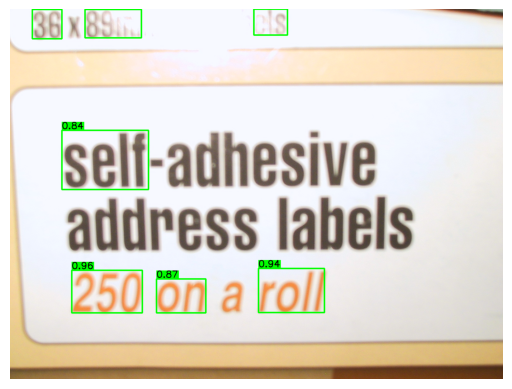

In [18]:
from ultralytics import YOLO

model_path = '/content/drive/MyDrive/AI/OCR/models/yolov8/detect/train/weights/best.pt'
img_path = '/content/drive/MyDrive/AI/OCR/datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG'
conf_thres=0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].tojson())
print(predictions[0])
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()

# CRNN - resnet101 để dự đoán text

In [19]:
img_paths = []
labels = []
with open('/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/labels.txt', 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 928


In [20]:
img_paths


['/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000000.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000001.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000002.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000003.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000004.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000005.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000006.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000007.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000008.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000009.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000010.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000011.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000012.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000013.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000014.jpg',
 '/content

In [21]:
# Tạo dictionary chuyển đổi kí tự (class) sang dạng số và ngược lại
chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [22]:
# Tìm label có độ dài lớn nhất
# Đặt làm max_label_len để padding
max_label_len = max([len(label) for label in labels])

In [23]:
def encode(label, char_to_idx, max_label_len):
    """
    Encode label thành tensor

    Paramaters:
        label (str): String label.
        char_to_idx (dict): Bảng mapping classname -> ID.
        max_label_len (int): Độ dài tối đa cho label.

    Returns:
        padded_labels (tensor): Tensor label đã được encode và padding.
        lengths (tensor): Độ dài trước khi padding của label.
    """
    # Đổi sang tensor
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.long
    )
    # Tính len của label
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    # Padding
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [24]:
input_str = 'hello'
encoded_labels, lengths = encode(input_str, char_to_idx, max_label_len)
print(encoded_labels)
print(lengths)

tensor([19, 16, 23, 23, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0])
tensor(5)


In [25]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    """
    Decode encoded label thành string

    Parameters:
        encoded_sequences (list): Danh sách các tensor label.
        idx_to_char (dict): Bảng mapping ID -> classname.
        blank_char (str): Kí tự "blank".

    Returns:
        decoded_sequences (list): danh sách các label đã được decode.
    """
    # Khai báo list rỗng chứa kết quả decode
    decoded_sequences = []

    # Duyệt qua từng encoded label
    for seq in encoded_sequences:
        # Khai báo list rỗng chứa từng kí tự đã decode
        decoded_label = []
        # Duyệt qua từng token
        for idx, token in enumerate(seq):
            # Bỏ qua token padding (ID=0)
            if token != 0:
                # Lấy kí tự của token đang xét trong idx_to_char
                char = idx_to_char[token.item()]
                # Bỏ qua kí tự "blank"
                if char != blank_char:
                    decoded_label.append(char)
        # Thêm chuỗi đã decode vào list decoded_sequences
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

In [26]:
decoded_sequences = decode([encoded_labels], idx_to_char)
print(decoded_sequences)

['hello']


# Chuẩn bị dữ liệu cho CRNN

In [27]:
from torchvision import models, transforms
# Khai báo hàm transform dữ liệu
data_transforms = {
    # Dành cho dữ liệu train
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=2, shear=2),
        transforms.RandomPerspective(
            distortion_scale=0.4,
            p=0.5,
            interpolation=3
        ),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    # Dành cho dữ liệu val, test
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

In [28]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [29]:
X_train

['/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000245.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000694.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000707.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000898.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000371.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000443.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000022.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000357.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000044.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000510.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000879.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000056.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000559.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000042.jpg',
 '/content/drive/MyDrive/AI/OCR/datasets/ocr_dataset/000531.jpg',
 '/content

In [30]:
from torch.utils.data import Dataset, DataLoader
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

In [31]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)



In [32]:
print(f"Train dataset: {len(train_dataset)}", f"Val dataset: {len(val_dataset)}", f"Test dataset: {len(test_dataset)}", sep='\n')

Train dataset: 649
Val dataset: 186
Test dataset: 93


In [33]:
train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['books', 'access', 'these', 'the', 'stop', 'the', 'royal', 'pantene', 'design', 'middleborough', 'lock', 'studio', 'red', '1809', 'diet', 'high', 'jenny', 'intelligent', 'colchester', 'physical', 'semi', 'inven', 'bequet', 'stirling', 'yarmouth', 'pro', '2002', 'sack', 'aircraft', 'chapman', 'estate', 'breakfast']


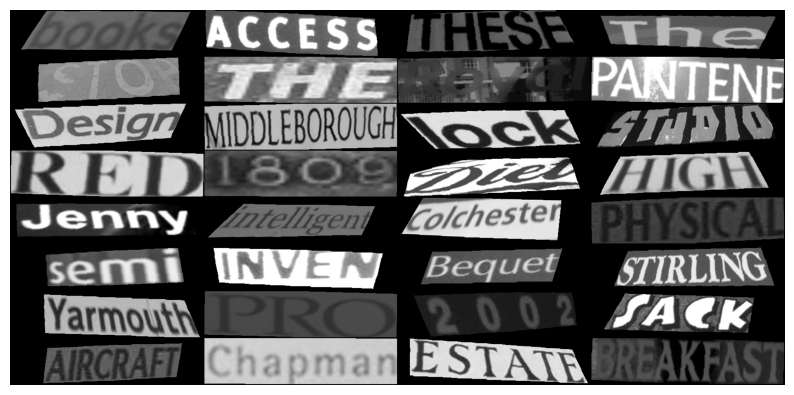

In [34]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

In [35]:
for batch in train_loader:
    print(1)
    inputs, labels, labels_len = batch
    print(inputs.shape)
    print(labels.shape)
    print(labels_len.shape)
    break

1
torch.Size([32, 1, 100, 420])
torch.Size([32, 14])
torch.Size([32])


# Model CRNN - Resnet101

In [36]:
class CRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2,
        unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        # Khởi tạo pretrained model resnet101
        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )
        # Bỏ đi lớp classifer gốc của pretrained
        modules = list(backbone.children())[:-2]
        # Thêm vào lớp AdaptiveAvgPool2d
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Mở băng (unfreeze) một số layers cuối cùng của pretrained model
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        # Layer dùng để map từ CNN features maps sang LSTM
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            1024, hidden_size,
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x) # shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2) # shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Remove h: (bs, w, c)
        x = self.mapSeq(x)
        x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x) # shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)

        return x

In [37]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Traing crnn

In [38]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(
                outputs, labels, logits_lens, labels_len
            )
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [39]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Tính len của model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            # Thực hiện gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        scheduler.step()

    return train_losses, val_losses

In [40]:
epochs = 100
lr = 0.001
weight_decay=1e-5
scheduler_step_size = epochs * 0.5
blank_char = '-'
criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


EPOCH 1:	Train loss: 3.9837	Val loss: 3.4418
EPOCH 2:	Train loss: 3.3916	Val loss: 3.4146
EPOCH 3:	Train loss: 3.3160	Val loss: 3.3052
EPOCH 4:	Train loss: 3.1615	Val loss: 3.2166
EPOCH 5:	Train loss: 2.9711	Val loss: 2.8814
EPOCH 6:	Train loss: 2.6677	Val loss: 2.4882
EPOCH 7:	Train loss: 2.3088	Val loss: 2.0906
EPOCH 8:	Train loss: 1.8424	Val loss: 1.7578
EPOCH 9:	Train loss: 1.3988	Val loss: 1.4017
EPOCH 10:	Train loss: 1.1523	Val loss: 1.0850
EPOCH 11:	Train loss: 0.9035	Val loss: 0.9862
EPOCH 12:	Train loss: 0.6596	Val loss: 0.8691
EPOCH 13:	Train loss: 0.5962	Val loss: 0.7710
EPOCH 14:	Train loss: 0.5507	Val loss: 0.8667
EPOCH 15:	Train loss: 0.5217	Val loss: 0.7909
EPOCH 16:	Train loss: 0.4765	Val loss: 0.7810
EPOCH 17:	Train loss: 0.4198	Val loss: 0.6982
EPOCH 18:	Train loss: 0.3915	Val loss: 0.7428
EPOCH 19:	Train loss: 0.3457	Val loss: 0.6976
EPOCH 20:	Train loss: 0.2806	Val loss: 0.6459
EPOCH 21:	Train loss: 0.2760	Val loss: 0.7638
EPOCH 22:	Train loss: 0.2655	Val loss: 0.70

In [41]:
save_model_path = '/content/drive/MyDrive/AI/OCR/models/ocr_crnn_resnet_best.pt'
torch.save(
    model.state_dict(),
    save_model_path
)

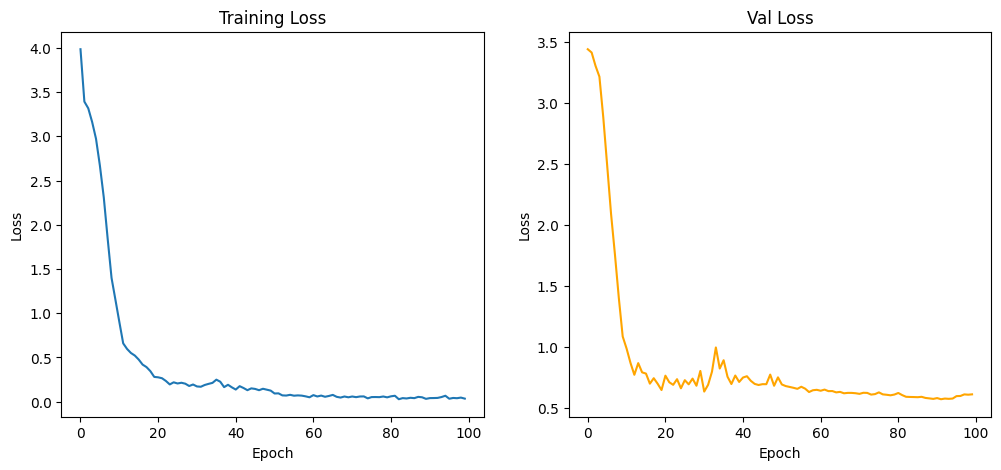

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [43]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  0.6105036177905276
Test loss:  0.597605268470943


# Predict

In [61]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%pip install SpellChecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 48.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for SpellChecker: filename=spellchecker-0.4-py3-none-any.whl size=3966500 sha256=de80f8afb07720a7430ce251c2b763e01958542dc95acb80fabc9cfad1987eb8
  Stored in directory: /root/.cache/pip/wheels/6c/90/c3/eac248d8755b2a7343487a2087b4b29ad98f388c3c8c69c286
  Created wheel for inexactsearch: filename=inexactsearch-1.0.2-py3-none-any.whl size=7123 sha256=7eb77f319ace9a1f90198b588da904e829839508997da5973630172cf4d0e0ee
  Stored in directory: /root/.cache/pip/wheels/63/19/2c/5e9f447f2533d457a1167c3e553f235e232b8a639e3f5fafab
  Created wheel for silpa_common: filename=silpa_common-0.3-py3-none-any.whl size=8466 sha256=85d76033278683ebc220c48a64ef249ad0cbbd9a51ac66c6a8f7a49427c638d6
  Stored in directory: /root/.cache/pip/wheels/c0/72/43/0c7

In [60]:
import re
from spellchecker import SpellChecker

def normalize_word(word):
    normalized_word = re.sub(r'(.)\1+', r'\1', word)
    return normalized_word

spell = SpellChecker()

def correct_word(word):
    normalized_word = normalize_word(word)
    corrected_word = spell.correction(normalized_word)
    return corrected_word

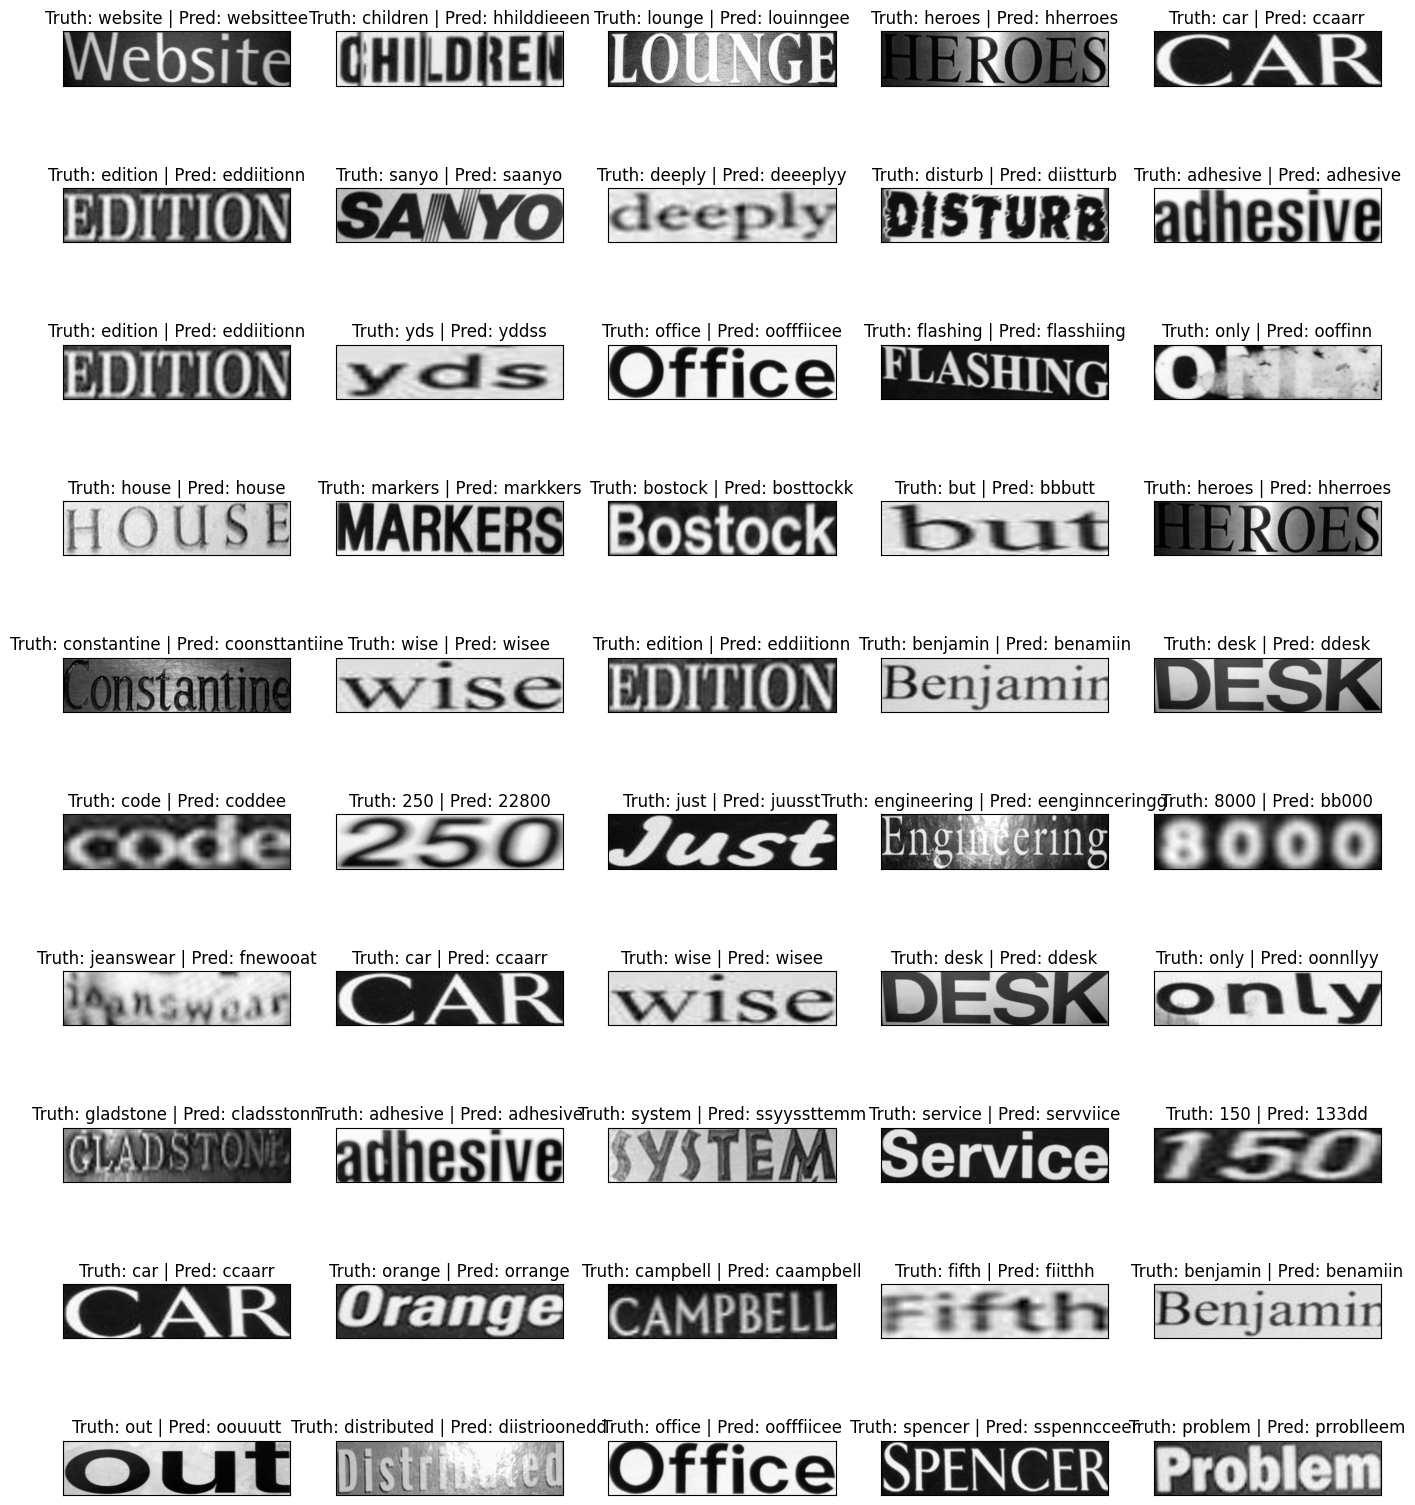

In [57]:

# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = test_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]
    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

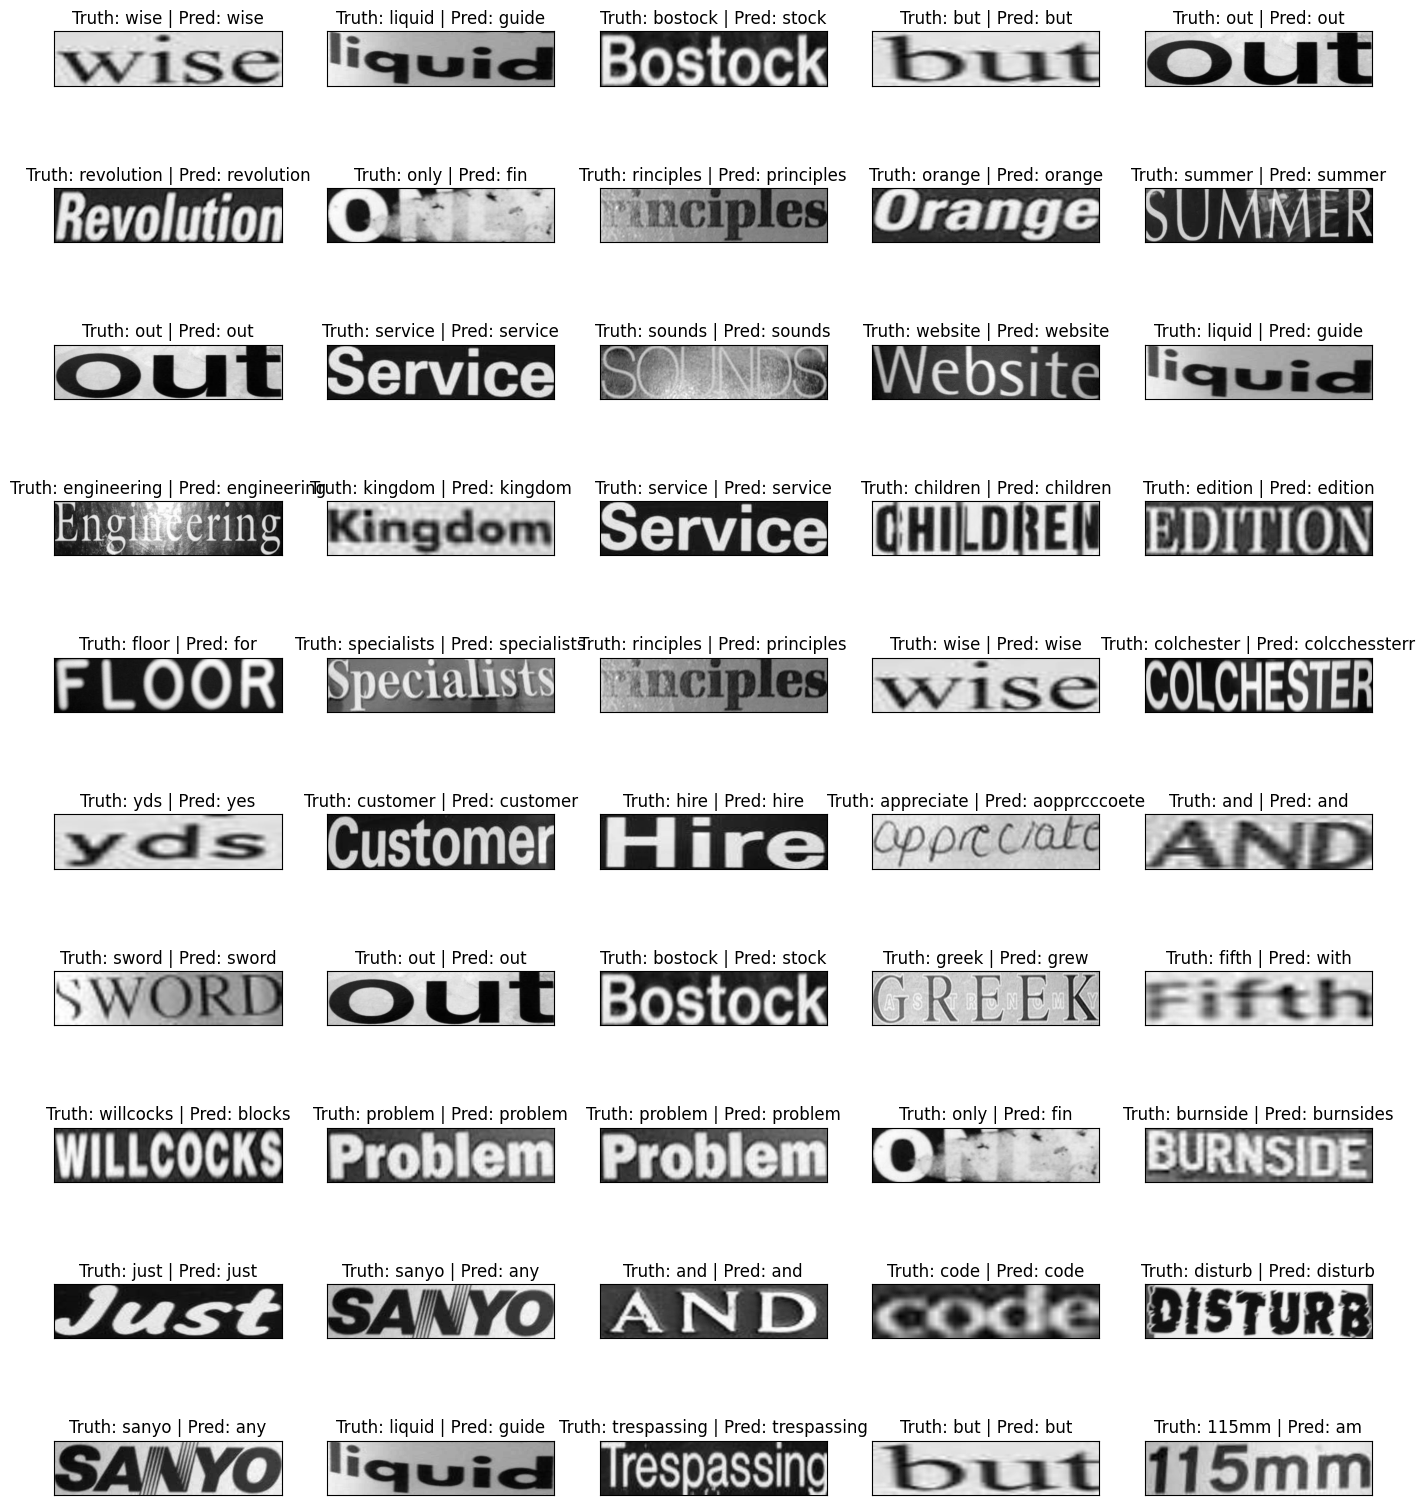

In [62]:

# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = test_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]
    pred = correct_word(pred_text)
    if pred != None:
      pred_text = pred
    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

In [63]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!zip /content/drive/MyDrive/AI/OCR.zip /content/drive/MyDrive/AI/OCR

  adding: content/drive/MyDrive/AI/OCR/ (stored 0%)
